In [ ]:
import tensorflow as tf
import numpy as np
import random
from util import *
import os
import cv2
import pandas as pd
import matplotlib.image as mpimg
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# train_csv_path = "/content/drive/MyDrive/Colab Notebooks/jwkr_cv/train.csv"
# train_img_path = "/content/drive/MyDrive/Colab Notebooks/jwkr_cv/train/"
train_csv_path = "tasks_ex/cv/train.csv"
train_img_path = "tasks_ex/cv/train/"
df = prepare_data(train_csv_path, train_img_path)


In [ ]:
class_1_df = df[df['label'] == 1]
class_0_df = df[df['label'] == 0]

augmented_class_0_images = []
for i, row in class_0_df.iterrows():
    image_path = row['image_path']
    augmented_class_0_images += augment_image(image_path, True)

augmented_class_0_paths = []
for i, img in enumerate(augmented_class_0_images):
    augmented_path = os.path.join(train_img_path, f"aug_class_0_{i}.jpg")
    cv2.imwrite(augmented_path, img)
    augmented_class_0_paths.append(augmented_path)

augmented_class_0_df = pd.DataFrame({
    'id': [f"aug_class_0_{i}.jpg" for i in range(len(augmented_class_0_images))],
    'image_path': augmented_class_0_paths,
    'label': [0] * len(augmented_class_0_images)
})

In [ ]:
balanced_df = pd.concat([df, augmented_class_0_df], ignore_index=True)

train_generator, val_generator = create_generators(balanced_df)

In [ ]:
red_prec = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(red_prec)
model = create_model()

base_model = model.layers[1]
for layer in model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

class_weights = {
    1: len(balanced_df[balanced_df['label']=='1']) / len(balanced_df),
    0: len(balanced_df[balanced_df['label']=='0']) / len(balanced_df)
}

history1 = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=get_callbacks(),
    class_weight=class_weights,
    batch_size=16
)

In [ ]:

# test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/jwkr_cv/cv_submission.csv')
# test_path = "/content/drive/MyDrive/Colab Notebooks/jwkr_cv/test"
test_df = pd.read_csv('efficient_submission.csv')
test_path = "../test/"
test_df['image_path'] = test_df['id'].apply(lambda x: os.path.join(test_path, x))
test_df['label'] = test_df['label'].astype(str)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=preprocess_image)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

predictions = model.predict(
    test_generator,
    steps=len(test_generator),
    verbose=1
)

In [ ]:
predictions = (predictions > 0.5).astype(int)
test_df['label'] = predictions
test_df = test_df[['id', 'label']]
test_df.to_csv('efficient_submission.csv', index=False)

In [ ]:
sampled_df = pd.read_csv('efficient_submission.csv').sample(n=300, random_state=42)
sampled_df['label'] = sampled_df['label'].astype(str)
test_path = "../test/"
sampled_df['image_path'] = sampled_df['id'].apply(lambda x: os.path.join(test_path, x))
combined_df = pd.concat([balanced_df, sampled_df], axis=0, ignore_index=True)

In [37]:
import tensorflow as tf
import numpy as np
import random
from util import *
import os
import cv2
import pandas as pd
import matplotlib.image as mpimg
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# train_csv_path = "/content/drive/MyDrive/Colab Notebooks/jwkr_cv/train.csv"
# train_img_path = "/content/drive/MyDrive/Colab Notebooks/jwkr_cv/train/"
train_csv_path = "tasks_ex/cv/train.csv"
train_img_path = "tasks_ex/cv/train/"
df = prepare_data(train_csv_path, train_img_path)


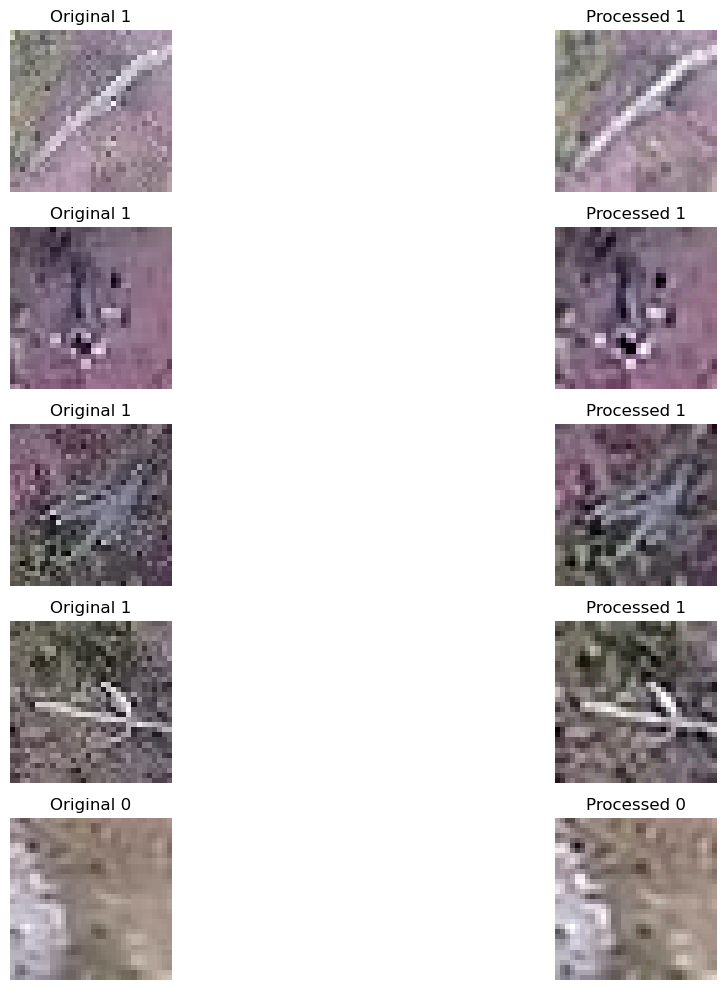

In [5]:
images = df.sample(n=5)

plt.figure(figsize=(15, 10))

for i, (_, row) in enumerate(images.iterrows()):
    img = cv2.imread(row['image_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(5, 2, 2*i+1)
    plt.imshow(img)
    plt.title(f"Original {row['label']}")
    plt.axis('off')

    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(preprocess_image(img))
    plt.title(f"Processed {row['label']}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [31]:
class_0_df = df.iloc[:4]

In [35]:
augmented_class_0_images = []
for i, row in class_0_df.iterrows():
    image_path = row['image_path']
    augmented_class_0_images += augment_image(image_path, True)

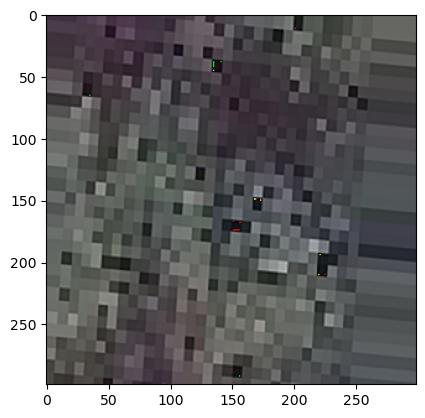

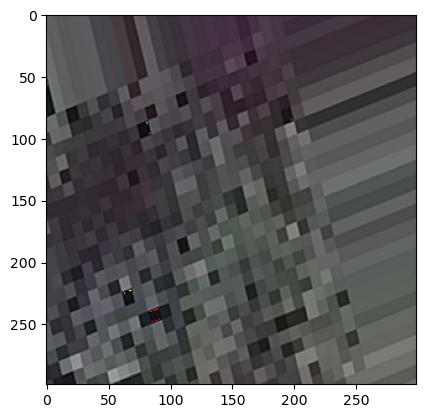

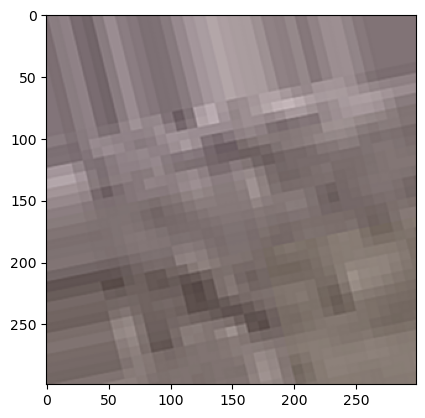

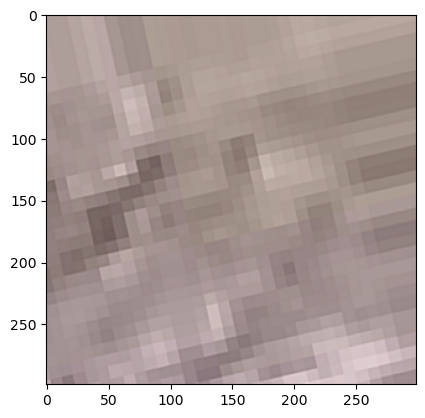

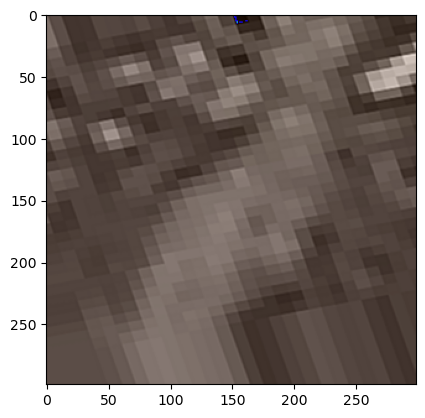

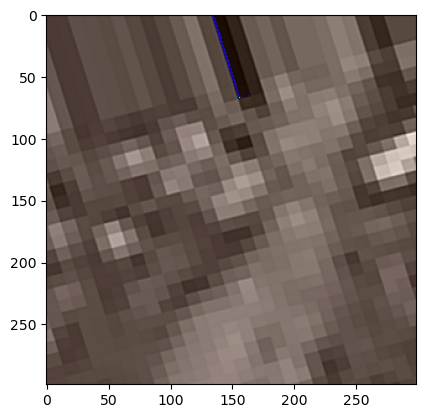

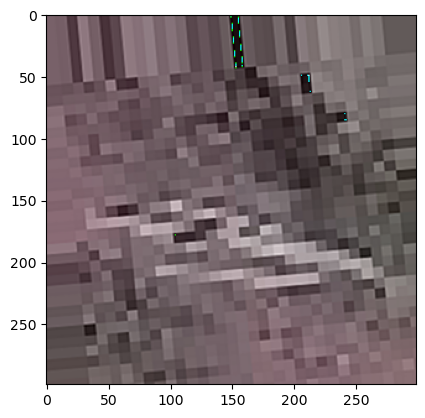

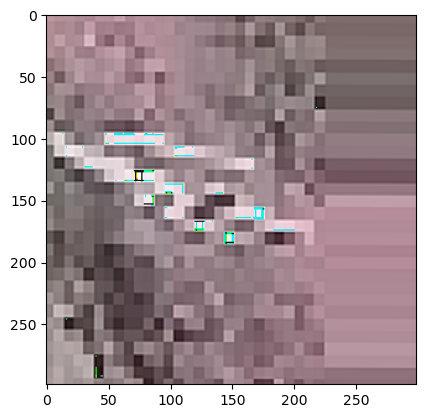

In [38]:
for img in augmented_class_0_images:
    plt.imshow(img)
    # plt.imshow(mpimg.imread(img))
    plt.show()


In [15]:
class_1_df = df[df['label'] == 1]
class_0_df = df[df['label'] == 0]

augmented_class_0_images = []
for i, row in class_0_df.iterrows():
    image_path = row['image_path']
    augmented_class_0_images += augment_image(image_path, True)

augmented_class_0_paths = []
for i, img in enumerate(augmented_class_0_images):
    augmented_path = os.path.join(train_img_path, f"aug_class_0_{i}.jpg")
    cv2.imwrite(augmented_path, img)
    augmented_class_0_paths.append(augmented_path)

augmented_class_0_df = pd.DataFrame({
    'id': [f"aug_class_0_{i}.jpg" for i in range(len(augmented_class_0_images))],
    'image_path': augmented_class_0_paths,
    'label': [0] * len(augmented_class_0_images)
})

In [16]:
balanced_df = pd.concat([df, augmented_class_0_df], ignore_index=True)

train_generator, val_generator = create_generators(balanced_df)

Found 229 validated image filenames belonging to 2 classes.
Found 77 validated image filenames belonging to 2 classes.


In [17]:
balanced_df.label.value_counts()


label
0    159
1    147
Name: count, dtype: int64

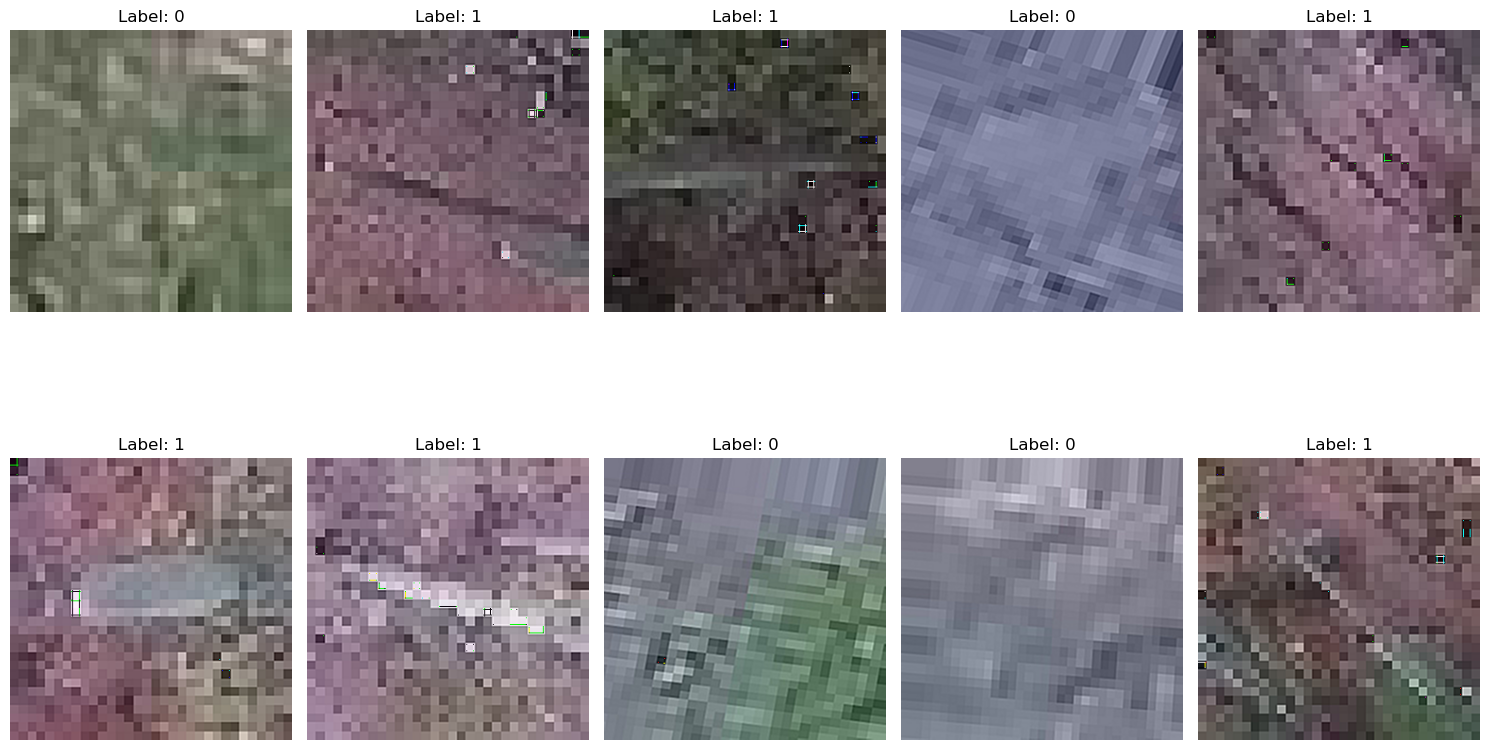

In [ ]:
import collections
images, labels = next(val_generator)

plt.figure(figsize=(15, 10))


for i in range(min(10, len(images))):
    plt.subplot(2, 5, i+1)
    img = images[i] * 255
    img = img.astype(np.uint8)
    plt.imshow(img)
    plt.title(f'Label: {int(labels[i])}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
red_prec = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(red_prec)
model = create_model()

base_model = model.layers[1]
for layer in model.layers[-30:]:
    layer.trainable = True
for layer in model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

class_weights = {
    0: len(balanced_df[balanced_df['label']=='1']) / len(balanced_df),
    1: len(balanced_df[balanced_df['label']=='0']) / len(balanced_df)
}

history1 = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=get_callbacks(),
    class_weight=class_weights,
    batch_size=16
)

AttributeError: 'Rescaling' object has no attribute 'layers'

In [ ]:
red_prec = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(red_prec)
model = create_model()

base_model = model.layers[1]
for layer in model.layers[-30:]:
    layer.trainable = True
for layer in model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

class_weights = {
    0: len(balanced_df[balanced_df['label']=='1']) / len(balanced_df),
    1: len(balanced_df[balanced_df['label']=='0']) / len(balanced_df)
}

history1 = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=get_callbacks(),
    class_weight=class_weights,
    batch_size=16
)

C:\Users\hash\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.5706 - auc_1: 0.6032 - loss: 0.4162 - precision_1: 0.5575 - recall_1: 0.5850 

8/8 ━━━━━━━━━━━━━━━━━━━━ 310s 35s/step - accuracy: 0.5717 - auc_1: 0.6026 - loss: 0.4184 - precision_1: 0.5579 - recall_1: 0.5846 - val_accuracy: 0.8442 - val_auc_1: 0.9139 - val_loss: 0.6816 - val_precision_1: 0.8205 - val_recall_1: 0.8649 - learning_rate: 5.0000e-05
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 252s 31s/step - accuracy: 0.7427 - auc_1: 0.8074 - loss: 0.2720 - precision_1: 0.7595 - recall_1: 0.7467 - val_accuracy: 0.5584 - val_auc_1: 0.9291 - val_loss: 0.6736 - val_precision_1: 1.0000 - val_recall_1: 0.0811 - learning_rate: 5.0000e-05
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 250s 31s/step - accuracy: 0.8188 - auc_1: 0.8865 - loss: 0.2196 - precision_1: 0.8020 - recall_1: 0.8060 - val_accuracy: 0.5195 - val_auc_1: 0.9382 - val_loss: 0.6676 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 5.0000e-05
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 252s 32s/step - accuracy: 0.8548 - auc_1: 0.9217 - loss: 0.1870 - precision_1: 0.8807 - recall_1: 0.8435 - val_accuracy: 0.5195

In [ ]:

# test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/jwkr_cv/cv_submission.csv')
# test_path = "/content/drive/MyDrive/Colab Notebooks/jwkr_cv/test"
test_df = pd.read_csv('efficient_submission.csv')
test_path = "../test/"
test_df['image_path'] = test_df['id'].apply(lambda x: os.path.join(test_path, x))
test_df['label'] = test_df['label'].astype(str)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=preprocess_image)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

predictions = model.predict(
    test_generator,
    steps=len(test_generator),
    verbose=1
)

In [ ]:
predictions = (predictions > 0.5).astype(int)
test_df['label'] = predictions
test_df = test_df[['id', 'label']]
test_df.to_csv('efficient_submission.csv', index=False)

In [36]:
sampled_df = pd.read_csv('efficient_submission.csv').sample(n=300, random_state=42)
sampled_df['label'] = sampled_df['label'].astype(str)
test_path = "../test/"
sampled_df['image_path'] = sampled_df['id'].apply(lambda x: os.path.join(test_path, x))
combined_df = pd.concat([balanced_df, sampled_df], axis=0, ignore_index=True)

In [42]:
# Training the model using predicted data
train_generator, val_generator = create_generators(combined_df)

red_prec = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(red_prec)
model = create_model()

base_model = model.layers[1]
for layer in model.layers[-30:]:
    layer.trainable = True
for layer in model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

class_weights = {
    0: len(balanced_df[balanced_df['label']=='1']) / len(balanced_df),
    1: len(balanced_df[balanced_df['label']=='0']) / len(balanced_df)
}

history1 = model.fit(
    train_generator,
    epochs=20,
    callbacks=get_callbacks(),
    class_weight=class_weights,
    batch_size=16
)

Found 454 validated image filenames belonging to 2 classes.
Found 152 validated image filenames belonging to 2 classes.


C:\Users\hash\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 95s/step - accuracy: 0.5697 - auc: 0.6154 - loss: 0.3904 - precision: 0.5910 - recall: 0.5654   

15/15 ━━━━━━━━━━━━━━━━━━━━ 1680s 111s/step - accuracy: 0.5724 - auc: 0.6188 - loss: 0.3885 - precision: 0.5923 - recall: 0.5692 - val_accuracy: 0.5000 - val_auc: 0.9778 - val_loss: 0.6742 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 5.0000e-05
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 584s 37s/step - accuracy: 0.7848 - auc: 0.8670 - loss: 0.2266 - precision: 0.7659 - recall: 0.8007 - val_accuracy: 0.5000 - val_auc: 0.9784 - val_loss: 0.6647 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 5.0000e-05
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 668s 45s/step - accuracy: 0.8320 - auc: 0.9085 - loss: 0.1936 - precision: 0.8176 - recall: 0.8458 - val_accuracy: 0.5000 - val_auc: 0.9742 - val_loss: 0.6574 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 5.0000e-05
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 721s 48s/step - accuracy: 0.8374 - auc: 0.9249 - loss: 0.1697 - precision: 0.8520 - recall: 0.8194 - val_accuracy: 0.5000 - val_auc: 0.9755 - val_loss: 0.6541 - 

: 

: 